# Sinclair DMA Exploration

This JUPYTER notebook explores Nielson Designated Market Areas (DMAs) and their application to the Sinclair Broadcast Group. 

In [270]:
# Load up some libraries
library(dplyr, warn.conflicts = FALSE)
library(geojsonio)
library(ggplot2)
library(broom)
library(rjson)
library(sp)
library(rgdal)
library(maps)
library(mapdata)
library(RColorBrewer)

In [80]:
dma_geo_path <- "Interactive_DMA_Map/nielsengeo.json"
dma_geo_json <- fromJSON(file = dma_geo_path)

In [218]:
point_in_polygon <- function(coor_list, lat, lon) {
    # A polygon needs at least 3 points so check for that
    len <- length(coor_list)
    if(len < 3) { stop("A polygon must have at least 3 coordinates") }
    
    # A boolean which determines if we think that the given point lies in the polygon
    is_inside <- FALSE
    
    # We will be looking at two points at a time from the coor_list
    for(idx1 in 1:len) {
        # Take care of wrapping
        idx2 <- if(idx1 == len) 1 else idx1 + 1
        
        # Extracting points for readability
        p1_lat <- coor_list[[idx1]][[2]]
        p1_lon <- coor_list[[idx1]][[1]]
        p2_lat <- coor_list[[idx2]][[2]]
        p2_lon <- coor_list[[idx2]][[1]]
        slope <- (p1_lat - p2_lat) / (p1_lon - p2_lon)
        
        # Check for same point
        if(is.nan(slope)) { next }
        
        #print(paste(p1_lat, p1_lon, p2_lat, p2_lon, slope, 1 / slope, sep = "|"))
        # Check if crossing along a line of constant latitude is possible
        is_between_lats <- (p1_lat > lat) != (p2_lat > lat)
        is_right_cross <- lon < ( (1 / slope) * (lat - p1_lat) + p1_lon )
        if(is_between_lats & is_right_cross) { is_inside <- !is_inside }
    }
    
    is_inside
}

In [231]:
point_in_geo <- function(geo_json, lat, lon) {
    # Default return value if we can't find anything
    to_return <- NULL

    # Filter out polygons from all of the features
    for(feature in geo_json$features) {
        # Extract type and coordinate list
        type <- feature$geometry$type
        coor <- feature$geometry$coordinates
        
        # Helper function to check single polygons
        in_single_polygon <- function(coor, lat, lon) {
            in_ring <- point_in_polygon(coor[[1]], lat, lon)
            in_hole <- FALSE
            if(length(coor) > 2) {
                for(hole in coor[2:length(coor)]) { 
                    in_hole <- if(in_hole) TRUE else point_in_polygon(hole, lat, lon) 
                }
            }
            in_ring & !in_hole
        }
        
        # Polygon check
        if(type == "Polygon") {
            if(in_single_polygon(coor, lat, lon)) { to_return <- feature }
        }
        if(type == "MultiPolygon") { 
            for(sub_coor in coor) {
                if(in_single_polygon(sub_coor, lat, lon)) { to_return <- feature; break }
            }
        }
                                   
        # Final check
        if(!is.null(to_return)) { break }
    }
    
    to_return
}

In [150]:
market_of_location <- function(geo_json, lat, lon) {
    # Get polygon that contains point (lat, lon)
    polygon <- point_in_geo(geo_json, lat, lon)
    if(is.null(polygon)) { stop("Could not find polygon for given location") }
    
    # Extract marketplace information from the returned object
    polygon$properties$dma1
}

In [142]:
sinclair_station_all_path <- "sinclair_station_all.csv"
sinclair_station_all_df <- read.csv(sinclair_station_all_path)

In [143]:
head(sinclair_station_all_df)

Market,Station,Channel.RF.,Year,Power.kW,Location,Latitude,Longitude,Year.Start,Year.End
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,21 (28),1995,765,33.484583; -86.807083,33.48458,-86.80708,1995,NA
"Birmingham - Tuscaloosa - Anniston, AL",WABM,68 (36),2001,885,33.484583; -86.807056,33.48458,-86.80706,2001,NA
"Birmingham - Tuscaloosa - Anniston, AL",WDBB,17 (18),1995,NA,,NA,NA,1995,NA
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,58 (40),2014,885,33.484583; -86.807056,33.48458,-86.80706,2014,NA
"Mobile, AL & Pensacola, FL",WEAR-TV,3 (17),1997,1000,30.612611; -87.644889,30.61261,-87.64489,1997,NA
"Mobile, AL & Pensacola, FL",WPMI-TV,15 (15),2012,1000,30.61139; -87.607333,30.61139,-87.60733,2012,NA


In [246]:
test_df <- na.omit(sinclair_station_all_df)
test_samples <- sample(1:nrow(test_df), 5)

for(test_sample in test_samples) {
    # Get the point of reference market from data
    real_market <- test_df[test_sample, "Market"]
    
    # Get the derived market from location
    test_lat <- test_df[test_sample, "Latitude"]
    test_lon <- test_df[test_sample, "Longitude"]
    test_market <- market_of_location(dma_geo_json, test_lat, test_lon)
    
    print(paste(real_market, "|", test_market))
}

[1] "St. Petersburg - Tampa | Tampa-St. Petersburg (Sarasota), FL"
[1] "Tallahassee, FL - Thomasville, GA | Tallahassee, FL-Thomasville, GA"
[1] "Lansing, Michigan | Lansing, MI"
[1] "Idaho Falls - Pocatello | Idaho Falls-Pocatello, ID"
[1] "Greenville, Tennessee (Tri-Cities, TN-VA) | Tri-Cities, TN-VA"


In [323]:
market_of_locations <- Vectorize(market_of_location, vectorize.args = c("lat", "lon"))

In [326]:
market_of_locations(dma_geo_json, 
                    test_df[test_samples, "Latitude"], 
                    test_df[test_samples, "Longitude"])

[1] "Tampa-St. Petersburg (Sarasota), FL" "Tallahassee, FL-Thomasville, GA"    
[3] "Lansing, MI"                         "Idaho Falls-Pocatello, ID"          
[5] "Tri-Cities, TN-VA"

In [328]:
sinclair_station_dma_df <- sinclair_station_all_df %>% 
    select(c("Market", "Station", "Latitude", "Longitude", "Year.Start", "Year.End")) %>%
    filter(!is.na(Latitude) & !is.na(Longitude)) %>%
    mutate(DMA = market_of_locations(dma_geo_json, Latitude, Longitude))

In [329]:
head(sinclair_station_dma_df)

Market,Station,Latitude,Longitude,Year.Start,Year.End,DMA
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,33.48458,-86.80708,1995,NA,"Birmingham (Anniston and Tuscaloosa), AL"
"Birmingham - Tuscaloosa - Anniston, AL",WABM,33.48458,-86.80706,2001,NA,"Birmingham (Anniston and Tuscaloosa), AL"
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,33.48458,-86.80706,2014,NA,"Birmingham (Anniston and Tuscaloosa), AL"
"Mobile, AL & Pensacola, FL",WEAR-TV,30.61261,-87.64489,1997,NA,"Mobile, AL-Pensacola (Ft. Walton Beach), FL"
"Mobile, AL & Pensacola, FL",WPMI-TV,30.61139,-87.60733,2012,NA,"Mobile, AL-Pensacola (Ft. Walton Beach), FL"
"Mobile, AL & Pensacola, FL",WFGX,30.61261,-87.64489,2001,NA,"Mobile, AL-Pensacola (Ft. Walton Beach), FL"


In [332]:
sinclair_dma_df <- sinclair_station_dma_df %>% 
    group_by(DMA) %>%
    summarize(Year.Start = min(Year.Start), Year.End = max(Year.End))

In [347]:
head(sinclair_dma_df)

DMA,Year.Start,Year.End
"Abilene-Sweetwater, TX",2017,NA
"Albany-Schenectady-Troy, NY",2012,NA
"Albany, GA",2013,NA
"Amarillo, TX",2013,NA
"Austin, TX",2012,NA
"Bakersfield, CA",2013,NA


In [312]:
# Get the shapefile
dma_geo_path <- "Interactive_DMA_Map/nielsengeo.json"
dma_geo_sh <- geojson_read(dma_geo_path, what = "sp")

# Convert the shapefile into a csv
dma_geo_sh@data$id <- rownames(dma_geo_sh@data)
dma_geo_df <- merge(tidy(dma_geo_sh), dma_geo_sh@data, by = "id")

Regions defined for each Polygons


In [345]:
head(dma_geo_df)

id,long,lat,order,hole,piece,group,name,latitude,tvperc,dma,dma1,cableperc,adsperc,longitude
500,-70.97725,43.35754,1,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-70.95991,43.54138,2,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.11016,43.50660,3,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.12750,43.57367,4,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.26042,43.57119,5,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301
500,-71.53203,43.76496,6,FALSE,1,500.1,dma:,44.36667,91.3,500,"Portland-Auburn, ME",67.9,23.7,-70.18301


In [396]:
sinclair_final_df <- merge(sinclair_dma_df, dma_geo_df, by.x = "DMA", by.y = "dma1")
sinclair_final_df <- sinclair_final_df %>%
    select(DMA, id, long, lat, order, hole, piece, group, Year.Start, Year.End)
sinclair_final_df <- sinclair_final_df[order(sinclair_final_df$id, sinclair_final_df$order),]

In [397]:
head(sinclair_final_df) 

,DMA,id,long,lat,order,hole,piece,group,Year.Start,Year.End
3227,"Portland-Auburn, ME",500,-70.97725,43.35754,1,FALSE,1,500.1,NA,NA
3167,"Portland-Auburn, ME",500,-70.95991,43.54138,2,FALSE,1,500.1,NA,NA
3316,"Portland-Auburn, ME",500,-71.11016,43.50660,3,FALSE,1,500.1,NA,NA
3277,"Portland-Auburn, ME",500,-71.12750,43.57367,4,FALSE,1,500.1,NA,NA
3278,"Portland-Auburn, ME",500,-71.26042,43.57119,5,FALSE,1,500.1,NA,NA
3209,"Portland-Auburn, ME",500,-71.53203,43.76496,6,FALSE,1,500.1,NA,NA


In [415]:
library(repr)
options(repr.plot.width=9, repr.plot.height=5)

In [416]:
plot_sinclair_dmas <- function(year) {
    # Separate the spatial data into four datasets
    plot_df <- sinclair_final_df %>%
        mutate(Acquired = case_when(
            (Year.Start < year) & (Year.End > year | is.na(Year.End)) ~ "acquired\nprevious years",
            Year.Start == year ~ "acquired\nthis year",
            Year.End == year ~ "sold\nthis year",
            TRUE ~ "not held")
        )
    
    # We don't want to show the DMAs that were not held during the given year
    held_mask <- plot_df$Acquired != "not held"
    plot_df <- plot_df[held_mask, ]
    factor_levels <- c("acquired\nprevious years", "acquired\nthis year", "sold\nthis year")
    plot_df$Acquired <- factor(plot_df$Acquired, levels = factor_levels)
    
    # Pick some nice colors
    nice_colors <- brewer.pal(3, "Set2")
    
    # Make the plot
    ggplot() +
        coord_map("albers", lat0 = 37.5, lat1 = 29.5) + 
        geom_polygon(data = dma_geo_df,
                     aes(x = long, y = lat, group = group),
                     color = "gray60") +
        geom_polygon(data = plot_df,
                     aes(x = long, y = lat, group = group, fill = Acquired),
                     color = "gray60") +
        scale_fill_manual(values = nice_colors, drop = FALSE) +
        theme(plot.title = element_text(hjust = 0.1, color="#666666", face="bold", size=20), 
            axis.text = element_blank(), 
            axis.line = element_blank(), 
            axis.ticks = element_blank(),
            axis.title = element_blank(),
            panel.border = element_blank(),
            legend.position = c(0.93, 0.5),
            legend.key.size = unit(1, "cm"),
            legend.text = element_text(size=12),
            legend.title = element_text(size=12),
            panel.grid = element_blank(),
            panel.background = element_blank()) +
        #guides(size=guide_legend(title="Transmitter\nPower (kW)"), byrow = TRUE) +
        ggtitle(paste("Sinclair DMAs in", year))
}

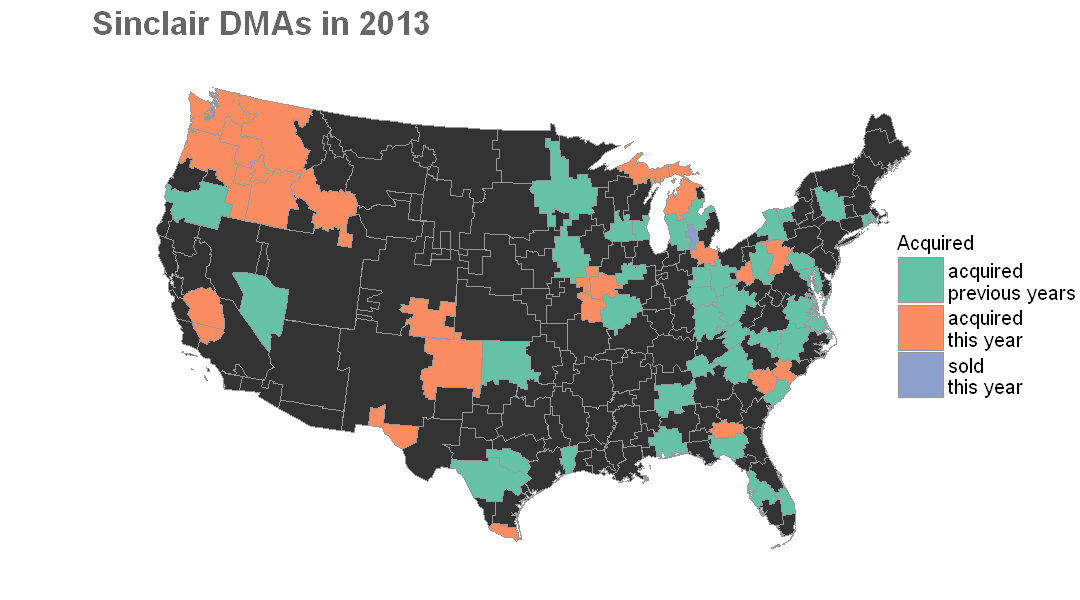

In [419]:
plot_sinclair_dmas(2013)

In [418]:
max_year <- max(sinclair_final_df$Year.Start, na.rm = TRUE)
min_year <- min(sinclair_final_df$Year.Start, na.rm = TRUE)

IMAGE_OUTPUT_PATH <- "Images"

for(year in min_year:max_year) {
    image <- plot_sinclair_dmas(year)
    image.name <- paste("Sinclair_DMAs", year, sep = "_")
    image.name <- paste(image.name, ".png", sep = "")
    ggsave(filename = image.name, 
        plot = image,
        path = IMAGE_OUTPUT_PATH,
        width = unit(14, "cm"),
        height = unit(10, "cm"))
}